In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_energy_data(file_path, target_col='building 41', test_size=0.2, random_state=42, lookback_window=24):
    """
    Complete preprocessing pipeline for energy demand prediction

    Parameters:
    - file_path: Path to the CSV file
    - target_col: Name of the target column (default 'building 41')
    - test_size: Proportion of data for test set (default 0.2)
    - random_state: Random seed for reproducibility (default 42)
    - lookback_window: Number of previous hours to use for time series features (default 24)

    Returns:
    - X_train, X_test, y_train, y_test: Preprocessed train/test sets
    - scaler: Fitted scaler object for inverse transformations
    """

    # 1. Load and clean data
    df = pd.read_csv(file_path, parse_dates=['Time'])
    df = df.sort_values('Time').reset_index(drop=True)

    # Handle missing values
    df = df.interpolate().dropna()

    # 2. Feature engineering
    # Time-based features
    df['hour'] = df['Time'].dt.hour
    df['day_of_week'] = df['Time'].dt.dayofweek
    df['month'] = df['Time'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Lag features
    for i in [1, 2, 3, 24, 48]:
        df[f'{target_col}_lag_{i}h'] = df[target_col].shift(i)

    # Rolling statistics
    df[f'{target_col}_rolling_24h_mean'] = df[target_col].rolling(window=24).mean()
    df[f'{target_col}_rolling_24h_std'] = df[target_col].rolling(window=24).std()
    df[f'{target_col}_rolling_7d_mean'] = df[target_col].rolling(window=168).mean()

    # Weather interaction features
    df['temp_rh_interaction'] = df['Temp'] * df['RH']
    df['wind_chill'] = 13.12 + 0.6215*df['Temp'] - 11.37*(df['FF']**0.16) + 0.3965*df['Temp']*(df['FF']**0.16)

    # Drop rows with NA values from lag features
    df = df.dropna()

    # 3. Feature selection
    features = [
        # Time features
        'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_weekend',

        # Lag features
        f'{target_col}_lag_1h', f'{target_col}_lag_24h', f'{target_col}_lag_48h',
        f'{target_col}_rolling_24h_mean', f'{target_col}_rolling_24h_std',

        # Weather features
        'Temp', 'RH', 'FF', 'FX', 'P', 'Q', 'DR',
        'temp_rh_interaction', 'wind_chill'
    ]

    # 4. Train-test split (time-series aware)
    test_size = int(len(df) * test_size)
    train = df.iloc[:-test_size]
    test = df.iloc[-test_size:]

    X_train = train[features]
    y_train = train[target_col]
    X_test = test[features]
    y_test = test[target_col]

    # 5. Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6. Create time series sequences (for RNN/LSTM models)
    def create_sequences(data, targets, window_size):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i+window_size])
            y.append(targets[i+window_size])
        return np.array(X), np.array(y)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, lookback_window)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, lookback_window)

    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_seq': X_train_seq,
        'X_test_seq': X_test_seq,
        'y_train_seq': y_train_seq,
        'y_test_seq': y_test_seq,
        'scaler': scaler,
        'features': features
    }

# Example usage
if __name__ == "__main__":
    # Load and preprocess data
    processed_data = preprocess_energy_data('/content/sample_data/merged_consumption_weather.csv')

    # Access processed data
    X_train = processed_data['X_train']
    X_test = processed_data['X_test']
    y_train = processed_data['y_train']
    y_test = processed_data['y_test']
    X_train_seq = processed_data['X_train_seq']
    X_test_seq = processed_data['X_test_seq']

    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Sequence training data shape: {X_train_seq.shape}")
    print(f"Sequence test data shape: {X_test_seq.shape}")



Training data shape: (20909, 19)
Test data shape: (5227, 19)
Sequence training data shape: (20885, 24, 19)
Sequence test data shape: (5203, 24, 19)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
processed_data = preprocess_energy_data('/content/sample_data/merged_consumption_weather.csv')

# Access processed data
X_train = processed_data['X_train']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_test = processed_data['y_test']
X_train_seq = processed_data['X_train_seq']
X_test_seq = processed_data['X_test_seq']
y_train_seq = processed_data['y_train_seq']
y_test_seq = processed_data['y_test_seq']
scaler = processed_data['scaler']
features = processed_data['features']


In [ ]:
# 1. Traditional Machine Learning Models
def train_traditional_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(alpha=0.1),
        'Ridge Regression': Ridge(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    }

    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        }

        print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")
        print("-" * 50)

    return results


In [ ]:
# 1. Traditional Machine Learning Models
def train_traditional_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(alpha=0.1),
        'Ridge Regression': Ridge(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    }

    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        }

        print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")
        print("-" * 50)

    return results


In [ ]:
# 2. LSTM Model
def train_lstm_model(X_train_seq, X_test_seq, y_train_seq, y_test_seq):
    print("Training LSTM model...")
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate
    y_pred = model.predict(X_test_seq).flatten()

    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    r2 = r2_score(y_test_seq, y_pred)

    print(f"LSTM - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

In [ ]:
# 3. Hyperparameter Tuning for Best Model
def tune_best_model(X_train, y_train, best_model_name):
    print(f"\nTuning {best_model_name}...")

    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = RandomForestRegressor(random_state=42)
    elif best_model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
        model = XGBRegressor(random_state=42)
    else:  # Default to Gradient Boosting
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = GradientBoostingRegressor(random_state=42)

    tscv = TimeSeriesSplit(n_splits=5)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best score: {-random_search.best_score_:.2f}")

    return random_search.best_estimator_


In [ ]:
# 4. Model Comparison and Visualization
def compare_models(results, lstm_results):
    # Combine all results
    all_results = results.copy()
    all_results['LSTM'] = lstm_results

    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Model': list(all_results.keys()),
        'MAE': [res['mae'] for res in all_results.values()],
        'RMSE': [res['rmse'] for res in all_results.values()],
        'R2': [res['r2'] for res in all_results.values()]
    }).sort_values('RMSE')

    print("\nModel Comparison:")
    print(comparison)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(comparison['Model'], comparison['RMSE'], color='skyblue')
    plt.title('RMSE Comparison')
    plt.xlabel('RMSE')

    plt.subplot(1, 2, 2)
    plt.barh(comparison['Model'], comparison['R2'], color='lightgreen')
    plt.title('R2 Score Comparison')
    plt.xlabel('R2 Score')

    plt.tight_layout()
    plt.show()

    return comparison

In [ ]:
# 5. Plot Predictions vs Actual
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true.values, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Energy Demand')
    plt.legend()
    plt.show()

Training traditional models...
Training Linear Regression...
Linear Regression - MAE: 0.76, RMSE: 1.11, R2: 0.98
--------------------------------------------------
Training Lasso Regression...
Lasso Regression - MAE: 0.78, RMSE: 1.16, R2: 0.97
--------------------------------------------------
Training Ridge Regression...
Ridge Regression - MAE: 0.76, RMSE: 1.11, R2: 0.98
--------------------------------------------------
Training Random Forest...
Random Forest - MAE: 0.73, RMSE: 1.10, R2: 0.98
--------------------------------------------------
Training Gradient Boosting...
Gradient Boosting - MAE: 0.68, RMSE: 1.01, R2: 0.98
--------------------------------------------------
Training XGBoost...
XGBoost - MAE: 0.73, RMSE: 1.08, R2: 0.98
--------------------------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

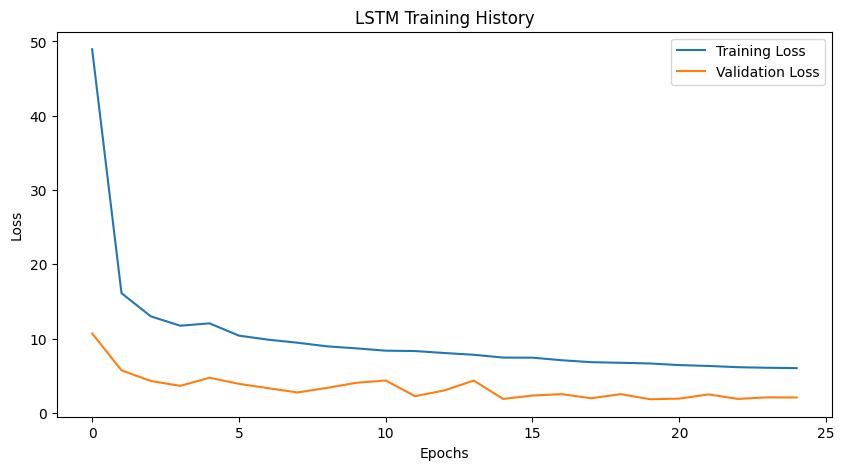


Model Comparison:
               Model       MAE      RMSE        R2
6           LightGBM  0.676698  1.009965  0.980818
4  Gradient Boosting  0.683464  1.013269  0.980692
5            XGBoost  0.734906  1.079369  0.978091
3      Random Forest  0.728825  1.095128  0.977446
2   Ridge Regression  0.757726  1.108022  0.976912
0  Linear Regression  0.757722  1.108022  0.976912
1   Lasso Regression  0.783017  1.155302  0.974900
8               LSTM  0.987602  1.360910  0.964954
7                SVR  1.192007  1.696621  0.945867


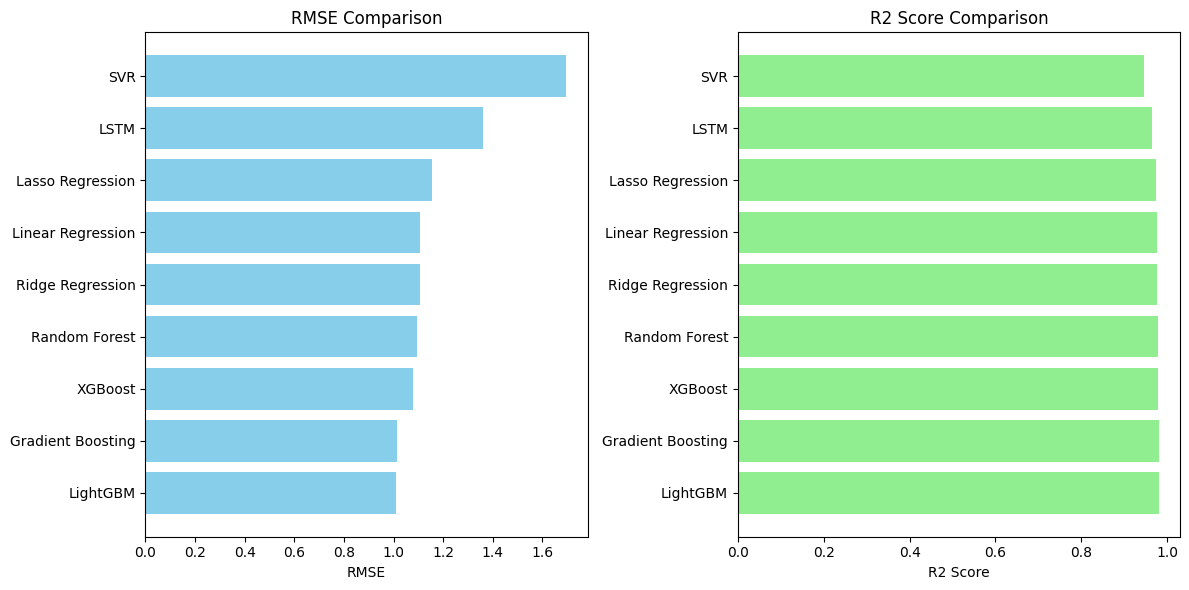


Best model: LightGBM


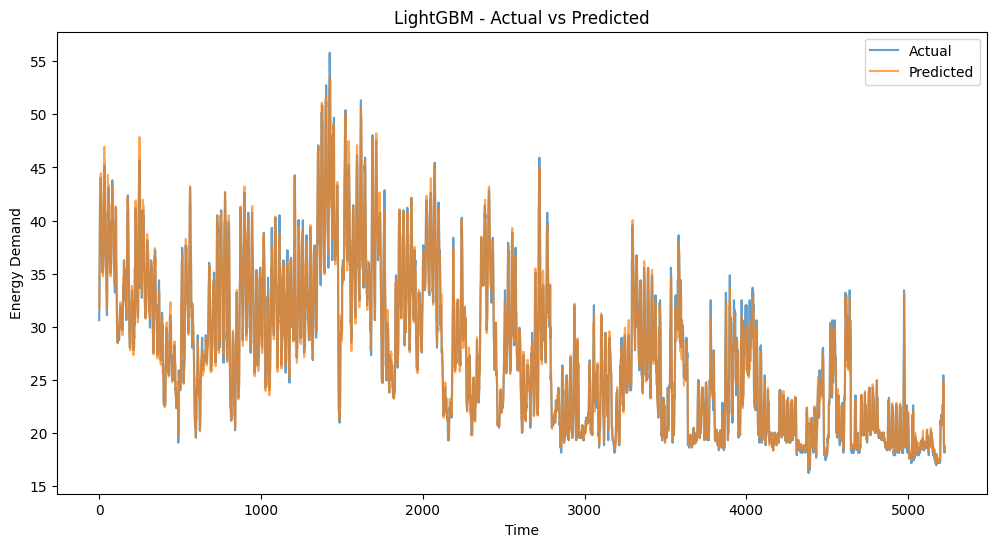


Tuning LightGBM...
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
Best score: 3.09

Tuned LightGBM - MAE: 0.68, RMSE: 1.01, R2: 0.98


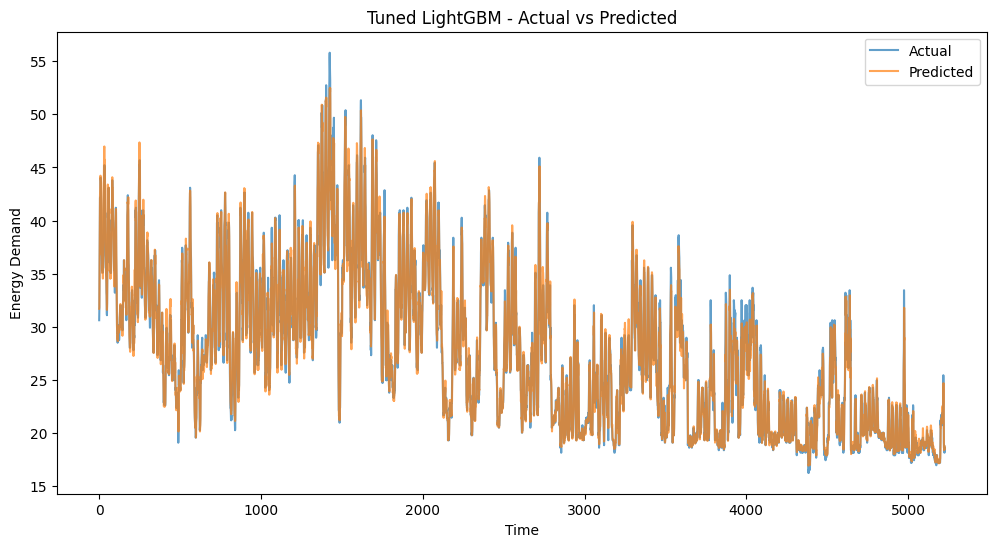

In [ ]:
# Main execution
if __name__ == "__main__":
    # Train traditional models
    print("Training traditional models...")
    traditional_results = train_traditional_models(X_train, X_test, y_train, y_test)

    # Train LSTM model
    print("\nTraining LSTM model...")
    lstm_results = train_lstm_model(X_train_seq, X_test_seq, y_train_seq, y_test_seq)

    # Compare all models
    comparison = compare_models(traditional_results, lstm_results)

    # Identify best model
    best_model_name = comparison.iloc[0]['Model']
    print(f"\nBest model: {best_model_name}")

    # Plot predictions for best model
    if best_model_name == 'LSTM':
        best_model = lstm_results['model']
        y_pred = best_model.predict(X_test_seq).flatten()
        plot_predictions(pd.Series(y_test_seq), y_pred, best_model_name)
    else:
        best_model = traditional_results[best_model_name]['model']
        y_pred = best_model.predict(X_test)
        plot_predictions(y_test, y_pred, best_model_name)

    # Hyperparameter tuning for best traditional model
    if best_model_name != 'LSTM':
        tuned_model = tune_best_model(X_train, y_train, best_model_name)
        y_pred_tuned = tuned_model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred_tuned)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
        r2 = r2_score(y_test, y_pred_tuned)

        print(f"\nTuned {best_model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

        # Plot predictions for tuned model
        plot_predictions(y_test, y_pred_tuned, f"Tuned {best_model_name}")